In [1]:
seed_value= 0

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Dot, Input, LSTM, TimeDistributed, SimpleRNN, Reshape
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model

In [3]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [4]:
dp_conf = [('ain',10),('aot',10),('m',10),('din',10),('dot',10)]
# dp_conf = [('ain',100)]
dp_val_range = 256

def getDpList():
    l = []
    for pair in dp_conf:
        dp = pair[0]
        num = pair[1]
        for i in range(num):
            l.append(dp+str(i))

    return l

def assignOperation(allDpList):
    l = []
    for dp in allDpList:
        for num in range(dp_val_range):
            num_str = str(num)
            
            x = "assign "+num_str +" to "+ dp
            
            if dp[0] == 'a':
                num_str+='.0'
                
            y = dp +"="+ num_str +";"
            l.append([x,y])
#             print([x,y])
  
    return l

def createDict(_li):
    _max_len = len(max(_li, key=len))
    
    sorted_li = sorted(list(set(''.join(_li))))
    sorted_li = ['<pad>'] + sorted_li

#     print(sorted_li)
    
    _dict = {sorted_li[i]: i for i in range(len(sorted_li))}
    _dict_inv = {i: sorted_li[i] for i in range(len(sorted_li))}    
    
    return _max_len, _dict, _dict_inv
    
def MaskingOneHot(oneHot):
    for record in oneHot:
        for feature in record:
            if(feature[0]) == 1.0:
                feature[0] = 0.0
#             print(feature[0])
    
#     print(oneHot)
    return oneHot

def createDataSet():
    dp_list = getDpList()
    
    dataset = []

    dataset += assignOperation(dp_list)
    
#     test_dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(20000)
#     dataset += test_dataset

    X, Y = zip(*dataset)
    
    Tx, X_dict, X_dict_inv = createDict(X)
    Ty, Y_dict, Y_dict_inv = createDict(Y)
    
    setting = {}
    setting['Tx'] = Tx
    setting['Ty'] = Ty
    setting['X_dict'] = X_dict
    setting['Y_dict'] = Y_dict
    setting['X_dict_inv'] = X_dict_inv
    setting['Y_dict_inv'] = Y_dict_inv
    x_vocab_len = len(X_dict)
    y_vocab_len = len(Y_dict)
    setting['x_vocab_len'] = x_vocab_len
    setting['y_vocab_len'] = y_vocab_len
    
    np.save("npy/setting.npy", setting)
    
    encoded_x = [[X_dict[j] for j in i] for i in X]
    encoded_y = [[Y_dict[j] for j in i] for i in Y]

    padded_x = pad_sequences(encoded_x, padding="post")
    padded_y = pad_sequences(encoded_y, padding="post")
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=x_vocab_len), padded_x)))
    Yoh = np.array(list(map(lambda y: to_categorical(y, num_classes=y_vocab_len), padded_y)))
#     Xoh = MaskingOneHot(Xoh)
#     Yoh = MaskingOneHot(Yoh)

    shuffled_Xoh, shuffled_Yoh = shuffle(Xoh, Yoh, random_state=seed_value) #0
#     shuffled_Xoh = Xoh
#     shuffled_Yoh = Yoh
    
#     shuffled_Xoh, _ = np.split(shuffled_Xoh, [int(len(shuffled_Xoh)*0.1)])
#     shuffled_Yoh, _ = np.split(shuffled_Yoh, [int(len(shuffled_Yoh)*0.1)])

    train_Xoh, test_Xoh = np.split(shuffled_Xoh, [int(len(shuffled_Xoh)*0.9)])
    train_Yoh, test_Yoh = np.split(shuffled_Yoh, [int(len(shuffled_Yoh)*0.9)])
    
    np.save('npy/train_Xoh.npy', train_Xoh)
    np.save('npy/test_Xoh.npy', test_Xoh)
    np.save('npy/train_Yoh.npy', train_Yoh)
    np.save('npy/test_Yoh.npy', test_Yoh)
    
def loadDataSet():
    setting = np.load('npy/setting.npy',allow_pickle='TRUE').item()
    
    train_Xoh = np.load('npy/train_Xoh.npy')
    test_Xoh = np.load('npy/test_Xoh.npy')
    train_Yoh = np.load('npy/train_Yoh.npy')
    test_Yoh = np.load('npy/test_Yoh.npy')
    
#     train_Xoh = MaskingOneHot(train_Xoh)
#     test_Xoh = MaskingOneHot(test_Xoh)
    
#     train_Yoh = MaskingOneHot(train_Yoh)
#     test_Yoh = MaskingOneHot(test_Yoh)
    
    return setting, train_Xoh, test_Xoh, train_Yoh, test_Yoh

createDataSet()
setting, train_Xoh, test_Xoh, train_Yoh, test_Yoh = loadDataSet()

Tx = setting['Tx']
Ty = setting['Ty']
X_dict = setting['X_dict']
Y_dict = setting['Y_dict']
X_dict_inv = setting['X_dict_inv']
Y_dict_inv = setting['Y_dict_inv']
x_vocab_len = setting['x_vocab_len']
y_vocab_len = setting['y_vocab_len']

print(Tx, Ty)
# print(X_dict)
# print(Y_dict)
# print(X_dict_inv)
# print(Y_dict_inv)
print(x_vocab_len, y_vocab_len)
print()
len(train_Xoh)

18 11
21 21



11520

In [5]:
# print(test_Xoh[0][0])
# print(''.join([X_dict_inv.get(j, '?') for j in np.argmax(test_Xoh[index], axis = -1)]).rstrip('<pad>'))

In [6]:
# print(X_dict)

In [7]:
# print(Y_dict)

In [8]:
pre_units = 32
post_units = 64

In [9]:
def RNN_Model_Single_Input():
    repeator = RepeatVector(2)
    pre_Reshape = Reshape((1, pre_units))
    post_Reshape = Reshape((1, post_units))
    
    decode_step = SimpleRNN(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation=softmax)

    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    h = h0

    outputs = []

    a = SimpleRNN(pre_units)(X)
    
    #-----------------------------------------------
    
    for t in range(Ty):
        if t == 0:
            a = repeator(a)
            a = post_Reshape(a)
        else:
            a = post_Reshape(h)
            
        h, _ = decode_step(a, initial_state=[h])
        out = output_Dense(h)
        outputs.append(out)

    model = Model(inputs=[X, h0], outputs=outputs)
    
    return model

def RNN_Model_Same_Input():
    decode_step = SimpleRNN(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation='softmax')

    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    h = h0

    outputs = []

    a = SimpleRNN(pre_units)(X)
    a = Reshape((1, pre_units))(a)
    
    #-----------------------------------------------
    
    for t in range(Ty):
        h, _ = decode_step(a, initial_state=[h])
        out = output_Dense(h)
        outputs.append(out)

    model = Model(inputs=[X, h0], outputs=outputs)
    
    return model

def LSTM_Model_Same_Input():
    decode_step = LSTM(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation='softmax')

    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    c0 = Input(shape=(post_units,), name='c0')
    h = h0
    c = c0

    outputs = []

    a = LSTM(pre_units)(X)
    a = Reshape((1, pre_units))(a)
    
    #-----------------------------------------------
    
    for t in range(Ty):
        h, _, s = decode_step(a, initial_state=[h, c])
        out = output_Dense(h)
        outputs.append(out)

    model = Model(inputs=[X, h0, c0], outputs=outputs)
    
    return model

def Bi_LSTM_Model_Same_Input():
    decode_step = LSTM(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation='softmax')

    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    c0 = Input(shape=(post_units,), name='c0')
    h = h0
    c = c0

    outputs = []

    a = Bidirectional(LSTM(pre_units))(X)
    a = Reshape((1, pre_units*2))(a)
    
    #-----------------------------------------------
    
    for t in range(Ty):
        h, _, s = decode_step(a, initial_state=[h, c])
        out = output_Dense(h)
        outputs.append(out)

    model = Model(inputs=[X, h0, c0], outputs=outputs)
    
    return model

def Bi_LSTM_Model_All_Input():
    decode_step = LSTM(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation='softmax')
    
    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    c0 = Input(shape=(post_units,), name='c0')
    h = h0
    c = c0

    outputs = []

    a = Bidirectional(LSTM(pre_units, return_sequences=True))(X)
    
    #--------------------------------------------------------------------------------------------------------

    for t in range(Ty):
        h, _, c = decode_step(a,initial_state=[h, c])

        out = output_Dense(h)
        outputs.append(out)

    
    model = Model(inputs=[X, h0, c0], outputs=outputs)
    
    return model

# repeator = RepeatVector(Tx)
# concatenator = Concatenate(axis=-1)
# densor1 = Dense(10, activation = "tanh")
# densor2 = Dense(1, activation = "relu")
# activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
# dotor = Dot(axes = 1)

# decode_step = LSTM(post_units, return_state = True)
# output_Dense = Dense(y_vocab_len, activation='softmax') ## 

# def one_step_attention(a, pre_h):
#     pre_h = repeator(pre_h)
#     concat = concatenator([a,pre_h])
#     e = densor1(concat)
#     energies = densor2(e)
#     alphas = activator(energies)
#     context = dotor([alphas,a])
    
#     return context

def Bi_LSTM_Model_Attention():
    repeator = RepeatVector(Tx)
    concatenator = Concatenate(axis=-1)
    densor1 = Dense(10, activation = "tanh")
    densor2 = Dense(1, activation = "relu")
    activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
    dotor = Dot(axes = 1)
    
    def one_step_attention(a, pre_h):
        pre_h = repeator(pre_h)
        concat = concatenator([a,pre_h])
        e = densor1(concat)
        energies = densor2(e)
        alphas = activator(energies)
        context = dotor([alphas,a])

        return context

    decode_step = LSTM(post_units, return_state = True)
    output_Dense = Dense(y_vocab_len, activation='softmax') ## 

    X = Input(shape=(Tx, x_vocab_len))
    h0 = Input(shape=(post_units,), name='h0')
    c0 = Input(shape=(post_units,), name='c0')
    h = h0
    c = c0

    outputs = []
    
    a = Bidirectional(LSTM(pre_units, return_sequences=True))(X)

    for t in range(Ty):
        context = one_step_attention(a, h)
        h, _, c = decode_step(context,initial_state=[h, c])
        out = output_Dense(h)
        outputs.append(out)
        
    model = Model(inputs=[X, h0, c0], outputs=outputs)
    
    return model

model = Bi_LSTM_Model_Attention()

# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
LR = 0.04927291
# LR = 0.005

In [11]:
d_model = 128
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=10):#4000
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) + 0.04927291 *0.8#0.8

learning_rate = CustomSchedule(d_model)

# opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [12]:
# opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, decay=0.01)#0.05
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
def get_attention_map(_model, file_name = False, index=29):
    s0 = np.zeros((1, post_units))
    c0 = np.zeros((1, post_units))
    
#     layer = model.layers[8]#7
    layer = _model.get_layer('attention_weights')
    
    oneHot_x = test_Xoh[index]#6 #16 #29
 

    input_text = [X_dict_inv.get(j, '?') for j in np.argmax(oneHot_x, axis = -1)]
    oneHot_x = oneHot_x.reshape((1,Tx,x_vocab_len))

    f = K.function(_model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([oneHot_x, s0, c0])
    
    prediction = _model.predict([oneHot_x, s0, c0])
    prediction = np.array(prediction).swapaxes(0,1)
    output_text = [Y_dict_inv.get(j, '?') for j in np.argmax(prediction[0], axis = -1)]
    
#     print(input_text)
#     print(output_text)
    
    attention_map = np.zeros((len(output_text), len(input_text)))
    
    for t in range(len(output_text)):
        for t_prime in range(len(input_text)):
            attention_map[t][t_prime] = r[t][0,t_prime,0]
            
    return attention_map

In [14]:
s0 = np.zeros((1, post_units))
c0 = np.zeros((1, post_units))
    
def get_predict_text(index=29):
    oneHot_x = test_Xoh[index]
 
    oneHot_x = oneHot_x.reshape((1,Tx,x_vocab_len))

    prediction = model.predict([oneHot_x, s0, c0])
    prediction = np.array(prediction).swapaxes(0,1)
    output_text = [Y_dict_inv.get(j, '?') for j in np.argmax(prediction[0], axis = -1)]
    
    return output_text

In [15]:
# path='./model_weights_0.04927291/'
# file_list=[img for img in  os.listdir(path)]


# for name in file_list:
#     source = name
#     target = name.replace("h5","npy")
#     model.load_weights('model_weights_0.04927291/'+source)
#     output_text = get_predict_text()
    
#     np.save('output_text/'+target, output_text)
        
# #     model.load_weights('model_weights/'+source)
# #     att_map = get_attention_map(model)
# #     np.save('attention_weights/'+target, att_map)


In [16]:
# path='./model_weights_0.04927291/'
# file_list=[img for img in  os.listdir(path)]

# for name in image_list:
#     source = name
#     target = name.replace("h5","npy")
    
#     model.load_weights('model_weights/'+source)
#     att_map = get_attention_map(model)
#     np.save('attention_weights/'+target, att_map)
#     print(source)
#     print(target)

In [17]:
h0 = np.zeros((len(train_Xoh), post_units))
c0 = np.zeros((len(train_Xoh), post_units))

outputs = list(train_Yoh.swapaxes(0,1))

In [18]:
vh0 = np.zeros((len(test_Xoh), post_units))
vc0 = np.zeros((len(test_Xoh), post_units))

voutputs = list(test_Yoh.swapaxes(0,1))

In [19]:
import datetime
log_dir="logs\\" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
# import matplotlib
# # matplotlib.use('Agg')
# %matplotlib inline

In [21]:
def evaluate(sentence):
    s0 = np.zeros((1, post_units))
    c0 = np.zeros((1, post_units))
    
#     layer = model.layers[8]#7
    layer = model.get_layer('attention_weights')
    
#     oneHot_x = test_Xoh[index]#6 #16 #29
    sentence = "assign 253 to aot8"
    enc_x = [X_dict[j] for j in sentence]
    pad_x = pad_sequences([enc_x], padding="post")
    oneHot_x = np.array(list(map(lambda x: to_categorical(x, num_classes=x_vocab_len), pad_x)))
    oneHot_x = oneHot_x[0]
 

    input_text = [X_dict_inv.get(j, '?') for j in np.argmax(oneHot_x, axis = -1)]
    oneHot_x = oneHot_x.reshape((1,Tx,x_vocab_len))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([oneHot_x, s0, c0])
    
    prediction = model.predict([oneHot_x, s0, c0])
    prediction = np.array(prediction).swapaxes(0,1)
    output_text = [Y_dict_inv.get(j, '?') for j in np.argmax(prediction[0], axis = -1)]
    
#     print(input_text)
#     print(output_text)
    
    attention_map = np.zeros((len(output_text), len(input_text)))
    
    for t in range(len(output_text)):
        for t_prime in range(len(input_text)):
            attention_map[t][t_prime] = r[t][0,t_prime,0]
    
    return output_text, attention_map

evaluate("assign 253 to aot8")
print()

In [22]:
def plot_attention_map(file_name = False, index=29):
    s0 = np.zeros((1, post_units))
    c0 = np.zeros((1, post_units))
    
#     layer = model.layers[8]#7
    layer = model.get_layer('attention_weights')
    
#     oneHot_x = test_Xoh[index]#6 #16 #29
    input_text = "assign 253 to aot8"
#     enc_x = [X_dict[j] for j in sentence]
#     pad_x = pad_sequences([enc_x], padding="post")
#     oneHot_x = np.array(list(map(lambda x: to_categorical(x, num_classes=x_vocab_len), pad_x)))
#     oneHot_x = oneHot_x[0]
 

#     input_text = [X_dict_inv.get(j, '?') for j in np.argmax(oneHot_x, axis = -1)]
#     oneHot_x = oneHot_x.reshape((1,Tx,x_vocab_len))

#     f = K.function(_model.inputs, [layer.get_output_at(t) for t in range(Ty)])
#     r = f([oneHot_x, s0, c0])
    
#     prediction = _model.predict([oneHot_x, s0, c0])
#     prediction = np.array(prediction).swapaxes(0,1)
#     output_text = [Y_dict_inv.get(j, '?') for j in np.argmax(prediction[0], axis = -1)]
    
# #     print(input_text)
# #     print(output_text)
    
#     attention_map = np.zeros((len(output_text), len(input_text)))
    
#     for t in range(len(output_text)):
#         for t_prime in range(len(input_text)):
#             attention_map[t][t_prime] = r[t][0,t_prime,0]

    output_text, attention_map = evaluate(input_text)
            

    input_length = len(input_text)
    output_length = len(output_text)#Ty

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    axData = ax.imshow(attention_map, cmap='viridis')
    colorBar = fig.colorbar(axData, orientation='horizontal',shrink=0.9)
    colorBar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)
    
    ax.set_xticks(range(input_length))
    ax.set_xticklabels(input_text, rotation=0)

    ax.set_yticks(range(output_length))
    ax.set_yticklabels(output_text)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    
    ax.grid()
    
    if file_name:
#         plt.savefig(file_name, dpi=300)
        plt.savefig(file_name)
        plt.close(fig)
        
# plot_attention_map()

In [23]:
def saveModelData(name):
    model.save_weights('model_weights/'+name+'.h5')

In [24]:
def saveAttData(epoch,batch):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    translated_text, attention_weights = evaluate(sentence)
    output_text = list(translated_text)
    name = str(epoch).zfill(5)+"_"+str(batch).zfill(5)
    np.save("att_data/npy_att/"+name+".npy", attention_weights)
    np.save("att_data/npy_outtext/"+name+".npy", output_text)

In [25]:
class CustomCallback(tf.keras.callbacks.Callback):
    epoch = 0
    def on_train_batch_end(self, batch, logs=None):
#         if self.epoch < 10:
#             name = str(self.epoch).zfill(4) +'_'+ str(batch).zfill(3)
        saveAttData(self.epoch,batch)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch

        plot_attention_map('attentionMap/'+str(epoch).zfill(4)+'_'+str(0).zfill(4)+'.png')
#       saveModelData(name)

        print("End "+str(epoch)+" epoch")

In [26]:
# model.save_weights('models/ini_model.h5')

In [27]:
# model.load_weights('model_weights_0.04927291/4999_000.h5')

In [28]:
# plot_attention_map(model)

In [29]:
# model.load_weights('models/tmp_model.h5')

In [30]:
# model.fit([train_Xoh, h0, c0], outputs, validation_data =([test_Xoh, vh0, vc0], voutputs),initial_epoch=50, epochs=1000, batch_size=100, verbose=0, callbacks=[CustomCallback(), tensorboard])

In [31]:
# model.fit([train_Xoh, h0, c0], outputs, epochs=1000, batch_size=int(pow(len(train_Xoh),0.5)), verbose=0, callbacks=[CustomCallback()])

In [32]:
LR

0.04927291

In [33]:
# model.fit([train_Xoh, h0, c0], outputs, initial_epoch=200, epochs=1000, batch_size=100, verbose=0, callbacks=[CustomCallback()])

In [34]:
# model.fit([train_Xoh, h0, c0], outputs, initial_epoch=0, epochs=2, batch_size=100, verbose=0, callbacks=[CustomCallback(),tensorboard])

In [35]:
# model.fit([train_Xoh, h0, c0], outputs, initial_epoch=0, epochs=30, batch_size=32, verbose=0,callbacks=[CustomCallback()])

In [36]:
model.fit([train_Xoh, h0, c0], outputs, initial_epoch=0, epochs=50, batch_size=100, verbose=0)

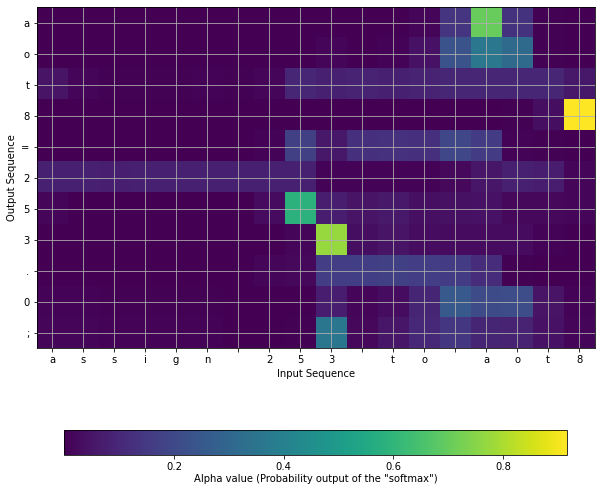

In [37]:
plot_attention_map()

In [40]:
# model.load_weights('model_weights/0000_000.h5')

In [41]:
# model.load_weights('model_weights_0.04927291/4999_000.h5')

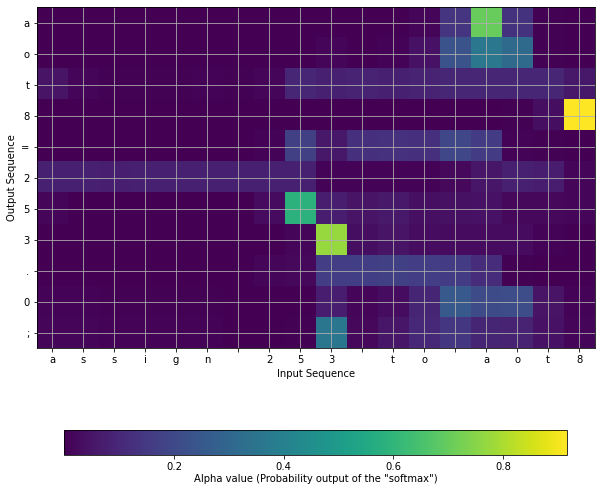

In [42]:
plot_attention_map()

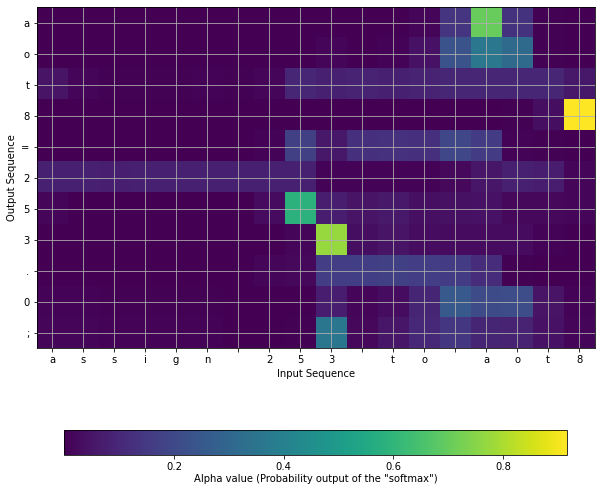

In [43]:
plot_attention_map()## 100 100

In [44]:
# model.save_weights('models/tmp_model_1.h5')

In [45]:
h0_t = np.zeros((len(test_Xoh), post_units))
c0_t = np.zeros((len(test_Xoh), post_units))

outputs_t = list(test_Yoh.swapaxes(0,1))

model.evaluate([test_Xoh, h0_t, c0_t], outputs_t, verbose=2)

1280/1280 - 6s - loss: 0.0018 - dense_2_loss: 7.2259e-05 - dense_2_1_loss: 1.3354e-04 - dense_2_2_loss: 8.4260e-05 - dense_2_3_loss: 5.0072e-04 - dense_2_4_loss: 1.1406e-04 - dense_2_5_loss: 3.6734e-04 - dense_2_6_loss: 2.3466e-04 - dense_2_7_loss: 1.5960e-04 - dense_2_8_loss: 5.3158e-05 - dense_2_9_loss: 4.2325e-05 - dense_2_10_loss: 4.3647e-05 - dense_2_accuracy: 1.0000 - dense_2_1_accuracy: 1.0000 - dense_2_2_accuracy: 1.0000 - dense_2_3_accuracy: 1.0000 - dense_2_4_accuracy: 1.0000 - dense_2_5_accuracy: 1.0000 - dense_2_6_accuracy: 1.0000 - dense_2_7_accuracy: 1.0000 - dense_2_8_accuracy: 1.0000 - dense_2_9_accuracy: 1.0000 - dense_2_10_accuracy: 1.0000


[0.0018055697408271953,
 7.225895e-05,
 0.00013353972,
 8.426043e-05,
 0.00050071895,
 0.00011406497,
 0.00036734322,
 0.00023465743,
 0.00015959606,
 5.3158157e-05,
 4.2324904e-05,
 4.364695e-05,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
batch_size = test_Xoh.shape[0]

h0_te = np.zeros((batch_size, post_units))
c0_te = np.zeros((batch_size, post_units))

prediction = model.predict([test_Xoh, h0_te, c0_te])
prediction = np.array(prediction).swapaxes(0,1)

In [ ]:
index = 29

print(''.join([X_dict_inv.get(j, '?') for j in np.argmax(test_Xoh[index], axis = -1)]).rstrip('<pad>'))
print(''.join([Y_dict_inv.get(j, '?') for j in np.argmax(prediction[index], axis = -1)]))
print(''.join([Y_dict_inv.get(j, '?') for j in np.argmax(test_Yoh[index], axis = -1)]))

In [ ]:
def plot_attention_map_from_file(epoch,batch):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    
    name = str(epoch).zfill(5)+"_"+str(batch).zfill(5)
#         setting = np.load('npy/setting.npy',allow_pickle='TRUE').item()
#     print(name)
    attention_map = np.load("att_data/npy_att/"+name+".npy",allow_pickle='TRUE')#.item()
    output_text = np.load("att_data/npy_outtext/"+name+".npy")

    input_length = len(input_text)
    output_length = len(output_text)#Ty

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    axData = ax.imshow(attention_map, cmap='viridis')
    colorBar = fig.colorbar(axData, orientation='horizontal',shrink=0.9)
    colorBar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)
    
    ax.set_xticks(range(input_length))
    ax.set_xticklabels(input_text, rotation=0)

    ax.set_yticks(range(output_length))
    ax.set_yticklabels(output_text)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    
    ax.grid()
    
#     if file_name:
#     plt.savefig('attentionMap/'+name+'.png', dpi=300)
#     plt.close(fig)
    
# plot_attention_map_from_file(28,350)